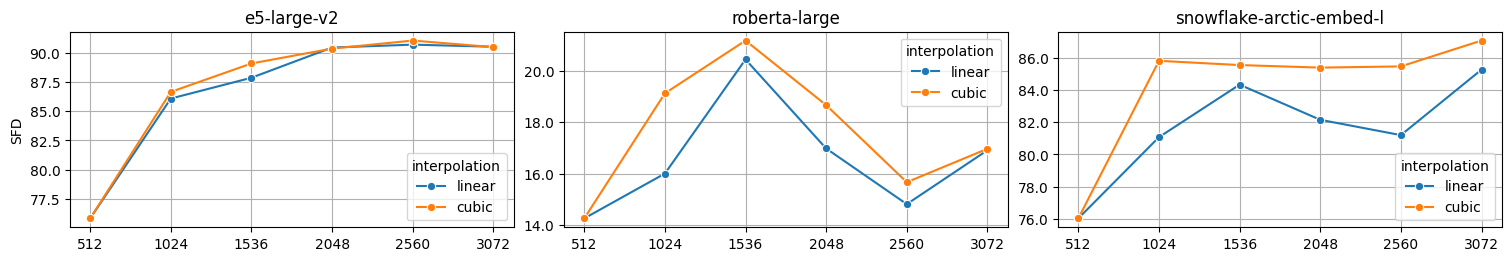

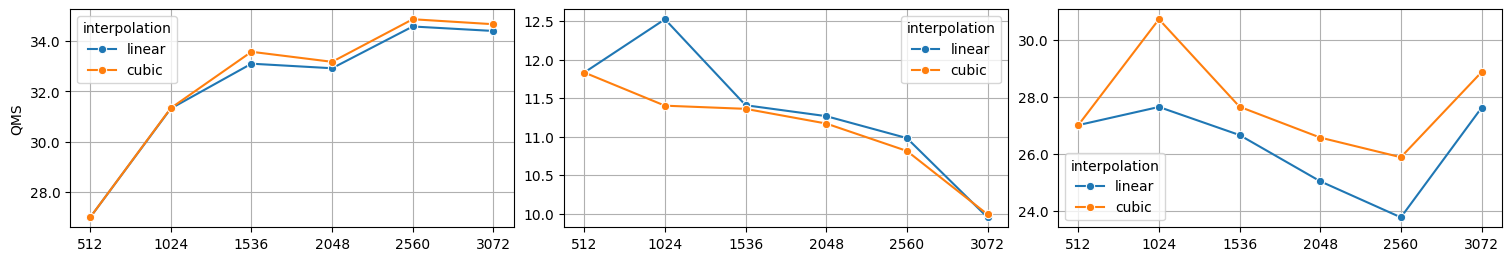

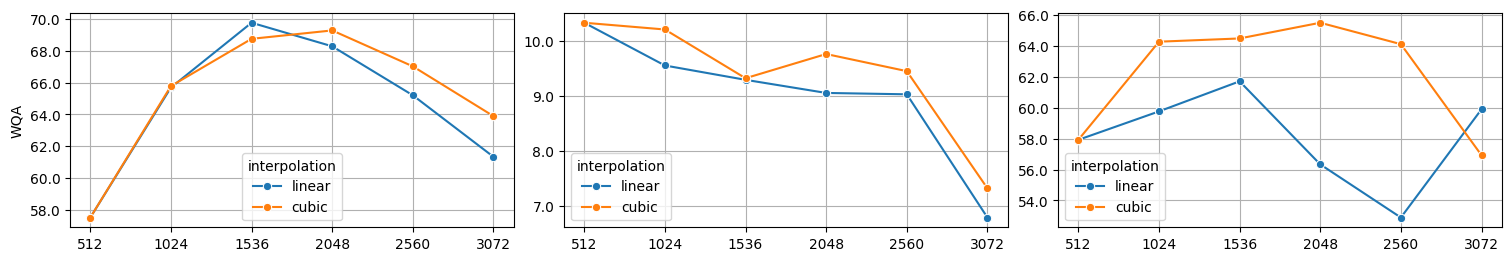

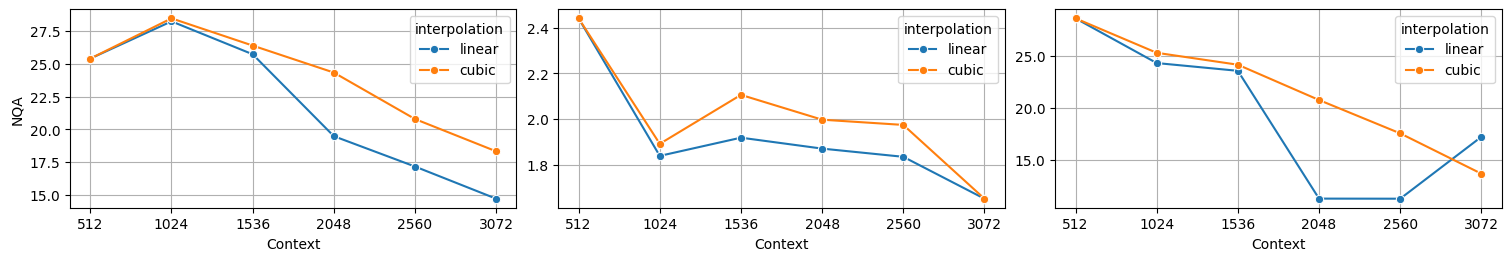

In [1]:
import re
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

CONFIG_PATTERN = r'^(?P<model>.+?)-ctx(?P<context>\d+)-(?P<interpolation>linear|cubic|quadratic)$'
METRIC = 'ndcg_at_10'
metric_col = METRIC.upper().replace('_AT_', '@')
data = {
    'model': [],
    'context': [],
    'interpolation': [],
    'dataset': [],
    metric_col: [],
}

dataset_aliases = {
    'LEMBNarrativeQARetrieval': 'NQA',
    'LEMBSummScreenFDRetrieval': 'SFD',
    'LEMBQMSumRetrieval': 'QMS',
    'LEMBWikimQARetrieval': 'WQA',    
}

paths = [p for p in Path('../results').rglob('*json') if p.stem != 'model_meta']
for path in paths:
    with open(path, 'r') as f:
        results = json.load(f)['scores']

    ndcg_at_10 = results[list(results.keys())[0]][0][METRIC]
    config = re.match(CONFIG_PATTERN, path.parent.parent.name).groupdict()
    for param, value in config.items():
        if param == 'model':
            value = value.split('__')[-1]
        data[param].append(value)

    data['dataset'].append(dataset_aliases[path.stem])
    data[metric_col].append(ndcg_at_10 * 100)

df = pd.DataFrame(data)

models = df['model'].unique()
datasets = df['dataset'].unique()
ncols = len(models)

for dataset in datasets:
    fig, axes = plt.subplots(
        1, ncols, figsize=(5 * ncols, 2.5), 
        # sharey=True,
        sharex=True, 
        constrained_layout=True
    )
    
    for i, model in enumerate(models):
        # select axis
        ax = axes[i] if ncols > 1 else axes

        # plot results
        df_filter = (df['dataset'] == dataset) & (df['model'] == model)
        sns.lineplot(
            data=df[df_filter],
            x='context',
            y=metric_col,
            hue='interpolation',
            marker='o',
            ax=ax
        )

        # set title for first plot
        if dataset == datasets[0]:
            ax.set_title(model)
        
        # set axes names
        ax.set_ylabel(f'{dataset}' if i == 0 else '')
        ax.set_xlabel('Context' if dataset == datasets[-1] else '')
        # ax.get_legend().remove()
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.grid(True)

    # plt.tight_layout()
    # plt.grid(True)
    # plt.show()
plt.savefig('results.png')


In [2]:
# df[['interpolation', metric_col]].groupby('interpolation').agg('mean')

In [3]:
def compute_interpolation_deltas(df, metric_col: str = metric_col):
    pivot = df.pivot_table(
        index=['model', 'context', 'dataset'],
        columns='interpolation',
        values=metric_col
    ).dropna(subset=['linear', 'cubic'])  # Ensure both exist

    # Calculate delta (cubic - linear)
    pivot['delta'] = pivot['cubic'] - pivot['linear']

    # Reset index to return a flat DataFrame
    return pivot.reset_index()

# df_filter = (df['model'] != 'roberta-large') & (df['context'] != '512')
df_filter = (df['context'] != '512')
# df_filter = (df['model'] != 'roberta-large') & (df['context'].apply(int) >= 1048)
deltas = compute_interpolation_deltas(df[df_filter])

In [4]:
deltas['delta'].mean(), deltas['delta'].std()

(np.float64(1.5243166666666668), np.float64(2.6260272468907155))

In [5]:
# sns.histplot(deltas['delta'], bins=20, kde=True)

In [6]:
from scipy.stats import shapiro, ttest_rel, wilcoxon


def cohens_d_paired(x, y):
    diffs = x.values - y.values
    return diffs.mean() / diffs.std(ddof=1)


data1 = deltas['cubic']
data2 = deltas['linear']
diffs = data1.values - data2.values

# normality check
_, shapiro_p = shapiro(deltas['delta'].values)
print(f'Shapiro-Wilk: p={shapiro_p:.3g}')

# test
if shapiro_p > 0.05:
    _, p_val = ttest_rel(data1, data2)  # use t-test
    print(f't-test: p={p_val:.3g}')
else:
    _, p_val = wilcoxon(data1, data2)  # use wilcoxon
    print(f'Wilcoxon: p={p_val:.3g}')

# effect size
cohens_d = cohens_d_paired(data1, data2)  # Cohen's d
print(f'Cohen\'s d: {cohens_d:.3g}')

# delta
delta = abs(data1.mean() - data2.mean())
print(f'Delta: {delta:.3g}')

Shapiro-Wilk: p=3.14e-07
Wilcoxon: p=2.43e-07
Cohen's d: 0.58
Delta: 1.52
